In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import csv
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn import tree
from sklearn import svm
from sklearn import linear_model
from sklearn.neighbors import KNeighborsRegressor
from sklearn.base import clone
import time
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')
# warnings.filterwarnings(action='once')

from GDELT_utils import dtype_dict_for_tone, \
                        init_sample, ICM_INT_sample, ICM_SPEC_sample, \
                        train_naive, train_pared, \
                        train_pared_URARE, train_pared_UWEAK, country_info, \
                        map_rare, unify_rare_cats

In [2]:
gdelt = pd.read_csv("gdelt_agg_big.csv",
                    dtype=dtype_dict_for_tone,
                   parse_dates=["SQLDATE"])
gdelt = gdelt.drop(labels=gdelt[(gdelt['EventRootCode'] == "--")].index)

In [3]:
example_samp = gdelt.sample(frac=.01)

# Introduction

In this report we're going to take a look at the data from the Global Data on Events, Location and Tone project, also known as GDELT. GDELT provides data on global events, storing such things as the type of the event, the actors involved, the location and the tone of documents that report on the event. It thus provides an abstract and data driven view of the world's affairs. It has been in operation since 2013, and has data available from January 1, 1979 to the present. For our sample of the data, we're focusing on a relatively arbitrary three month period of 2017 from May 1 to August 1.

Our focus will be on building predictive models of the AvgTone information provided in the GDELT dataset. This column aggregates the average tone of the documents talking about the event which has been recorded in the data. This can give an overall tone of the narrative that has developed around an event. We will find that the relationships are highly non-linear and that decision trees and derived ensemble models based on them perform well. 

# Data Introduction

The columns from the GDELT dataset that we have are focused on for building our models in addition to AvgTone are "SQLDATE", "EventRootCode", "NumMentions", "Actor1CountryCode", "Actor1Type1Code", "Actor1Geo_CountryCode", as well as these latter "Actor1" prefixed columns also having an "Actor2" variant. For the purposes of modeling, the mean of AvgTone was taken across records with the same "SQLDATE", "Actor1CountryCode", "Actor2CountryCode", "Actor1Type1Code", "Actor2Type1Code", "Actor1Geo_CountryCode", "Actor2Geo_CountryCode", and "EventRootCode". "NumMentions" was also averaged in this process.

The actor codes (except for the Geo fields) and EventRootCodes are encoded in the CAMEO code system. CAMEO codes capture the concept of "two actors and the action performed by Actor1 upon Actor2." An overview of CAMEO codes can be found at [this link](https://www.gdeltproject.org/data/documentation/CAMEO.Manual.1.1b3.pdf). 

A brief description of the data columns follows, while a more exhaustive description can be found in the [GDELT Data Format Documentation](http://data.gdeltproject.org/documentation/GDELT-Data_Format_Codebook.pdf).
* SQLDATE is an iso-encoded year, month and day. 
* EventRootCode is the root of the CAMEO code encoding the event. This is a very coarse understanding of the CAMEO event, indicating broad "verbs" of the action performed by Actor1 upon Actor2 like: "Make Public Statement", "Appeal", "Demand", "Disapprove", "Protest", "Fight", etc. Generally as the number increases, the verb indicates increasing degrees of aggression and violence, with 01 being "Make a Public Statement" and 20 being "Engage in Unconventional Mass Violence."
* Actor1CountryCode (Actor2CountryCode) codes the country affiliation of Actor1 (Actor2) as encoded in the CAMEO system.
* Actor1Type1Code (Actor2Type1Code) codes the "type" or "role" of Actor1 (Actor2). This can be something specific such as "Police Forces" or more broad such as "Refugees" or "Media". 
* Actor1Geo_CountryCode (Actor2Geo_CountryCode) is an addition to the CAMEO system which encodes the location of Actor1 (Actor2) when performing the action.
* NumMentions is the total number of mentions of the event across all source documents including multiple references within the same document. This can be used as a rough approximation of the "importance" and "scale" of an event.
* AvgTone is the average "tone" of all documents containing one or more mentions of this event. The scores range from -100 (extremely negative) to +100 (extremely positive) while most values are between -10 and 10. This can also give a sense of the "impact" of an event, e.g. a riot with a small negative average tone is likely a minor occurrence, whereas with one with a large negative average tone is a more serious one. 

In [4]:
gdelt.dropna().head()

,SQLDATE,Actor1CountryCode,Actor2CountryCode,Actor1Type1Code,Actor2Type1Code,Actor1Geo_CountryCode,Actor2Geo_CountryCode,EventRootCode,AVG(NumMentions),AVG(AvgTone)
34109,2017-05-01,AFG,AFG,COP,INS,AF,AF,19,14.6,-8.089026
34115,2017-05-01,AFG,AFG,ELI,INS,AF,AF,11,5.0,-3.412073
34128,2017-05-01,AFG,AFG,GOV,GOV,AF,AF,02,6.0,1.463415
34129,2017-05-01,AFG,AFG,GOV,GOV,AF,AF,03,16.0,-0.283871
34130,2017-05-01,AFG,AFG,GOV,GOV,AF,AF,04,6.0,1.844229


We should get a general idea of the distribution of the variable we're attemping to predict.

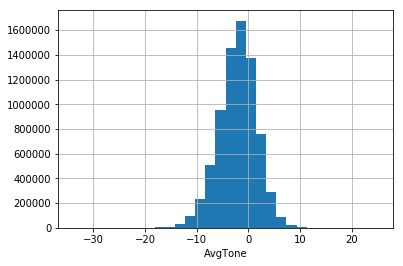

In [5]:
gdelt['AVG(AvgTone)'].hist(bins=30);
plt.xlabel("AvgTone");

We see that it is approximately normal, with a minor left skew.

# Data Preparation and Feature Engineering

As mentioned in the last section, the data has already been aggregated up to find means of our AvgTone and NumMentions columns. In this section we will explore the features of our dataset and consider various ways engineer them into more predictive features.

First, we look at NumMentions. We will find that this value has a large skew to it, with a majority of values being under 500.

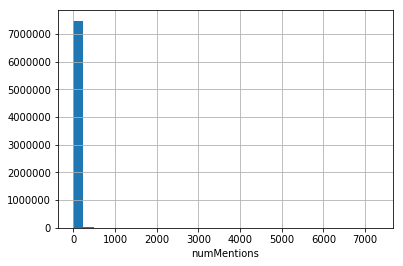

In [6]:
gdelt['AVG(NumMentions)'].hist(bins=30);
plt.xlabel("numMentions");

To help smooth this data, we will normalize it.

In [7]:
example_samp['norm_NumMentions'] = (example_samp['AVG(NumMentions)'] - example_samp['AVG(NumMentions)'].mean())/ \
                                        example_samp['AVG(NumMentions)'].std()

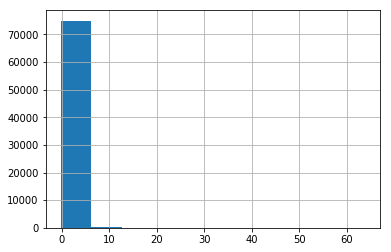

In [8]:
example_samp['norm_NumMentions'].hist();

Next, we explore the distribution of values in the country codes. To effectively visualize this, we first bin some of the rarer codes into their own label.

In [9]:
unify_rare_cats(example_samp, "Actor1CountryCode", .0075)

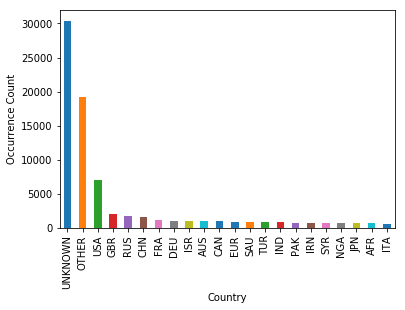

In [10]:
example_samp['Actor1CountryCode_unify'].cat.remove_unused_categories() \
                            .value_counts().plot(kind="bar");
plt.xlabel("Country")
plt.ylabel("Occurrence Count");

We see that there are quite a few records without a known country code and that there is a large concentration of occurrences in relatively small percentage of the data. This makes sense, as we would expect places with more of a media presence to generate more exhaustive media coverage of events. It does indicate that we should be careful and generalizing a model over the entire dataset, in case that some features which are unique to a country are not present in others.

We repeat this analysis for our other categorical columns regarding Actor1 as well as EventRootCode. This procedure can also be repeated for Actor2 columns.

In [11]:
unify_rare_cats(example_samp, "Actor1Type1Code", .01)
unify_rare_cats(example_samp, "Actor1Geo_CountryCode", .01)

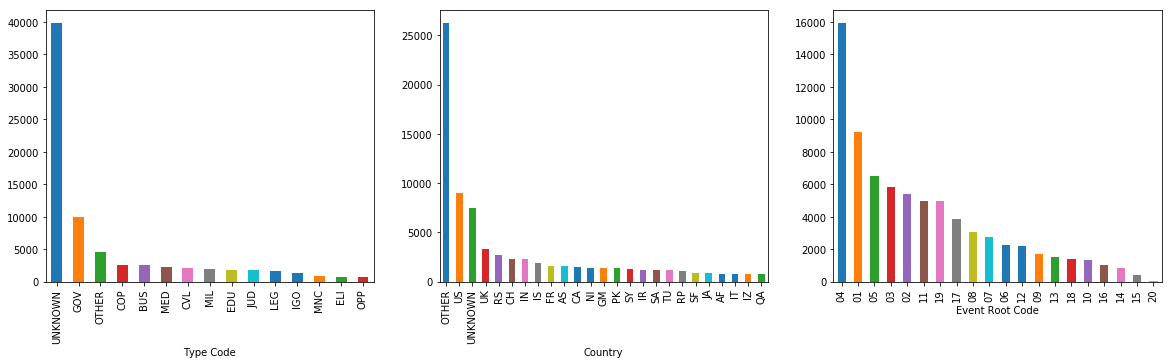

In [12]:
# Actor1Type1Code, Actor1Geo_CountryCode, EventRootCode
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20,5))

plt.subplot(1, 3, 1)
example_samp['Actor1Type1Code_unify'].cat.remove_unused_categories() \
                .value_counts().plot(kind='bar');
plt.xlabel('Type Code');
             
plt.subplot(1, 3, 2)
example_samp['Actor1Geo_CountryCode_unify'].cat.remove_unused_categories() \
                .value_counts().plot(kind='bar');
plt.xlabel('Country');

plt.subplot(1, 3, 3)
example_samp['EventRootCode'].cat.remove_unused_categories() \
                .value_counts().plot(kind='bar');
plt.xlabel('Event Root Code');

We see in the type codes there are quite a few unknowns. Additionally GOV occurs quite often. For Actor1Geo_CountryCode, we see that a lot of actions take place within the United States, but it still pares in comparison to the total amount of actions that occur in countries which appear more rarely. Finally for the EventCodes, our five most common verbs are "Consult", "Make Public Statement", "Engage in Diplomatic Cooperation", "Express Intent to Cooperate", and "Appeal".

So far, our investigation indicates that we have a lot of categorical columns with a lot of missing values. To handle them, we'll create dummy indicator values for each category which does come with the risk of a much higher dimension problem space. We'll also map any unknown values to the value "UNK" before training our models. 

There are some more sophisticated methods of dimensionality reduction we can try with our categories, like only preserving countries which have "enough" records, and mapping all others to "OTHER". We could also try a more sophisticated method of only preserving those countries which have a statistically significant and large AvgTone difference, as measured by taking the overall mean of all countries as the population mean, and measuring the deviance of a particular country from this mean. However, it turns out that neither of this methods do much to improve predictive accuracy, and so we do not discuss these any further in this report.

What we do build our models on is rather simple. We partition our dataset out by "Actor1CountryCode", so for example, we build individual models for "USA" and "GBR". This helps to isolate us from the noise and/or conflicting signals that may arise from different characteristics of countries when involved in some action upon Actor2. 

If we want further dimensionality reduction, we can also consider "Actor2CountryCode" as reduced to whether Actor1 is the same as Actor2. What this means is the country of the actors was the same, and in sense the event was "Internal". This distinction appears to capture a lot of the variance contributed by the "Actor2CountryCode" column, but we will achieve higher accuracy including the full range of values. We have a lot of data, and so the dimensionality increase can be compensated for, at the expense of additional compute time.

Finally, we will find that "Actor1Geo_CountryCode" and "Actor2Geo_CountryCode" appear to explain very little variance in the AvgTone, and so we will quickly omit those columns from our training. This will reduce some of the gain in dimensionality from including "Actor2CountryCode". 

# Model Exploration

We first build a relatively small sample of our data to try initial quick model constructions to get an idea of their accuracy. The init_sample function drops the "SQLDATE" column, normalizes "NumMentions" as "norm_NumMentions" and drops the "NumMentions" column, and cleans our categories to omit unused categories.

We distinguish between "naive" samples, which include all of the columns, and "pared" samples which omit the colums "Actor1Geo_CountryCode" and "Actor2Geo_CountryCode". In each set of samples, both naive and pared, we train models on the entire sample, the sample restricting "Actor1CountryCode" to "USA" and the sample restricting "Actor1CountryCode" and mapping "Actor2CountryCode" to the boolean of whether Actor1 is the same as Actor2.

In [13]:
test_samp = init_sample(gdelt, .1)
naive_samps = [("Naive Sample                  ", test_samp), 
               ("N, Actor1CC=USA, Internal?    ", ICM_INT_sample(test_samp, 'USA')), 
               ("N, Actor1CC=USA, Actor2CC     ", ICM_SPEC_sample(test_samp, 'USA'))]
pared_samps = [("Pared Sample                  ", test_samp), 
               ("P, Actor1CC=USA, Internal?    ", ICM_INT_sample(test_samp, 'USA')), 
               ("P, Actor1CC=USA, Actor2CC     ", ICM_SPEC_sample(test_samp, 'USA'))]

Our function below accepts an untrained model as input and naive or pared samples to train the model on. It then reports training and testing accuracy from our training functions. Note that our training functions use a consistent train_test split between each sample. We also note that there is no cross validation being used. 

In [14]:
def eval_model(model, samps, naive, trim_verbose=True, report=True):
    if report:
        print("Sample Type                   ", "Training Time     ", "Train Set Acc     ", "Test Set Acc     ")
    trained_models = []
    model_samps = []
    all_trs = []
    all_tes = []
    for samp_name, samp in samps:
        start_time = time.time()
        regr = clone(model)
        trained_model, model_samp, trs, tes = None, None, None, None
        if naive:
            trs, tes, trained_model, model_samp, _, _ = train_naive(samp, regr)
        else:
            trs, tes, trained_model, model_samp, _, _ = train_pared(samp, regr)
        trained_models.append(trained_model)
        model_samps.append(model_samp)
        all_trs.append(trs)
        all_tes.append(tes)
        if tes < 0:
            if trim_verbose:
                tes = "R^2 is < 0."
            else:
                tes = 0
            if report:
                print(samp_name,  "{:.{}f}              ".format(time.time() - start_time, 2), 
                      "{:.{}f}           ".format(trs, 5), "R^2 is negative.")
        else:
            if report:
                print(samp_name,  "{:.{}f}              ".format(time.time() - start_time, 2),
                      "{:.{}f}           ".format(trs, 5), "{:.{}f}".format(tes, 5))
            continue
    return trained_models, model_samps, all_trs, all_tes

## Linear Regression

We explore various approaches to predicting AvgTone with linear regressions models, both with regularization and without. For regularization techniques, we test both Lasso (L1) and Ridge (L2). First, we look at linear regression without regularization.

In [17]:
models_1, models_samps_1, _, _ = eval_model(linear_model.LinearRegression(), naive_samps, True)
#models_1[0].coef_

models_2, models_samps_2, _, _ = eval_model(linear_model.LinearRegression(), pared_samps, False)
#models_2[0].coef_

Sample Type                    Training Time      Train Set Acc      Test Set Acc     
Naive Sample                   57.07               0.28582            R^2 is negative.
N, Actor1CC=USA, Internal?     2.58               0.27237            R^2 is negative.
N, Actor1CC=USA, Actor2CC      3.75               0.28137            R^2 is negative.
Sample Type                    Training Time      Train Set Acc      Test Set Acc     
Pared Sample                   26.27               0.27304            R^2 is negative.
P, Actor1CC=USA, Internal?     0.26               0.22978            0.22804
P, Actor1CC=USA, Actor2CC      1.11               0.25607            R^2 is negative.


Basic linear regression performs quite poorly, sometimes even returning negative R^2 values. This means that the residual sum of squares is greater than the total variance from the mean! This is a terrible fit. Let's see if we can determine why this is taking place by looking at the normalized values of the coefficients.

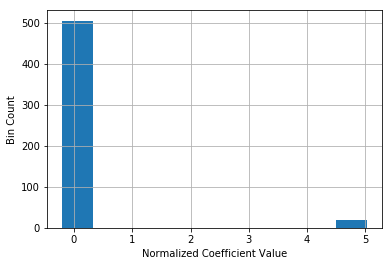

In [18]:
coef_series = pd.Series(models_2[0].coef_,
                           index=models_samps_2[0].drop(['AVG(AvgTone)'], axis=1).columns)
((coef_series - coef_series.mean()) / coef_series.std()).hist();
plt.xlabel('Normalized Coefficient Value');
plt.ylabel('Bin Count');

We see that a few coefficients exist far outside the range of the other coefficients. We can also observe directly that these coefficients are very large, on the order of $10^{11}$ while most are between $10^{-2}$ and $10^2$. This large degree of variance in the coefficients, as well as the large intercept, are out of proportion the values we're attempting to predict and thus suggest something has gone wrong.

In [27]:
print("Example large coefficient: ", coef_series.sort_values().iloc[-5])
print("Example small coefficient: ", coef_series.sort_values().iloc[5])
print("Intercept: ", models_2[0].intercept_)

Example large coefficient:  123137839397.62184
Example small coefficient:  -2.321799556296821
Intercept:  -123137839398.50183


Let's attempt a Ridge regression to control the size of coefficients.

In [28]:
models_3, _, _, _= eval_model(Ridge(), naive_samps, True)
#models_3[0].coef_

models_4, models_samps_4, _, _ = eval_model(Ridge(), pared_samps, False)
#models_4[0].coef_

Sample Type                    Training Time      Train Set Acc      Test Set Acc     
Naive Sample                   31.69               0.28581            0.28096
N, Actor1CC=USA, Internal?     1.02               0.27194            0.26043
N, Actor1CC=USA, Actor2CC      1.28               0.28081            0.26508
Sample Type                    Training Time      Train Set Acc      Test Set Acc     
Pared Sample                   9.17               0.27303            0.26907
P, Actor1CC=USA, Internal?     0.15               0.22977            0.22808
P, Actor1CC=USA, Actor2CC      0.54               0.25592            0.25296


And indeed our accuracy improves considerably, and provides consistent positive $R^2$ results. In fact, Ridge will, on average, outperform all models that we try below. We also see that our normalized coefficients form a more reasonable distribution.

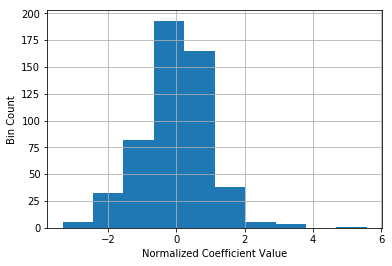

In [29]:
coef_series = pd.Series(models_4[0].coef_,
                           index=models_samps_4[0].drop(['AVG(AvgTone)'], axis=1).columns)
((coef_series - coef_series.mean()) / coef_series.std()).hist();
plt.xlabel('Normalized Coefficient Value');
plt.ylabel('Bin Count');

Finally, we test Lasso. It will perform similarly to Ridge once we tune our "alpha" parameter, the amount of weight we apply to Lasso's additional regularization cost. Without it, Lasso has a peculiar behavior in this context which we now demonstrate.

In [32]:
models_5, _, _, _ = eval_model(Lasso(alpha=1), naive_samps, True)
models_5[0].coef_

models_6, _, _, _ = eval_model(Lasso(alpha=1), pared_samps, False)
models_6[0].coef_

Sample Type                    Training Time      Train Set Acc      Test Set Acc     
Naive Sample                   18.01               0.00000            R^2 is negative.
N, Actor1CC=USA, Internal?     0.94               0.00000            R^2 is negative.
N, Actor1CC=USA, Actor2CC      1.23               0.00000            R^2 is negative.
Sample Type                    Training Time      Train Set Acc      Test Set Acc     
Pared Sample                   9.12               0.00000            R^2 is negative.
P, Actor1CC=USA, Internal?     0.15               0.00000            R^2 is negative.
P, Actor1CC=USA, Actor2CC      0.58               0.00000            R^2 is negative.


array([-0.,  0., -0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0., -0.,  0.,  0.,  0., -0.,  0., -0.,  0.,  0.,  0.,  0., -0.,
        0.,  0.,  0.,  0.,  0., -0.,  0.,  0.,  0.,  0., -0., -0., -0.,
       -0.,  0., -0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0., -0.,  0., -0., -0., -0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0., -0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -0., -0.,
        0., -0.,  0.,  0.,  0., -0., -0.,  0., -0., -0.,  0., -0.,  0.,
        0., -0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -0.,  0., -0.,
        0., -0.,  0.,  0.,  0.,  0.,  0.,  0., -0.,  0.,  0.,  0., -0.,
       -0., -0.,  0.,  0., -0.,  0., -0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0., -0., -0.,  0.,  0.,  0.,  0.,  0., -0.,  0.,  0., -0., -0.,
        0.,  0., -0.,  0.,  0.,  0., -0.,  0.,  0., -0., -0., -0.,  0.,
        0.,  0.,  0.,  0., -0., -0.,  0.,  0.,  0.,  0.,  0.,  0., -0.,
       -0.,  0., -0.,  0.,  0.,  0.,  0.,  0.,  0., -0., -0.,  0

All of the coefficients are forced to zero! This could be due to the fact that initial fit is so incorrect, that the residual sum of squares starts off larger than the total sum of squares. And so perhaps the only way to minimize the error during coordinate descent is to get $R^2$ to zero, rather than improving its positive range.

In [34]:
models_5, _, _, _ = eval_model(Lasso(alpha=.0001), naive_samps, True)

models_6, _, _, _ = eval_model(Lasso(alpha=.0001), pared_samps, False)

Sample Type                    Training Time      Train Set Acc      Test Set Acc     
Naive Sample                   60.31               0.28472            0.28084
N, Actor1CC=USA, Internal?     1.94               0.27041            0.26141
N, Actor1CC=USA, Actor2CC      2.75               0.27866            0.26716
Sample Type                    Training Time      Train Set Acc      Test Set Acc     
Pared Sample                   21.44               0.27232            0.26866
P, Actor1CC=USA, Internal?     0.43               0.22974            0.22810
P, Actor1CC=USA, Actor2CC      1.11               0.25528            0.25358


## SVM

We only briefly show SVM here to show how infeasible it is in practice for this data set. The training time on limited iterations is much too long, and the accuracy doesn't begin to compare with our Ridge/Lasso models. Also note that we're only using the pared samples here and it still takes this long.

In [70]:
models_10 = eval_model(svm.SVR(max_iter=100), pared_samps, False)

Sample Type                    Training Time      Train Set Acc      Test Set Acc     
Pared Sample                   70.84               -1.79330            R^2 is negative.
P, Actor1CC=USA, Internal?     1.15               -1.24713            R^2 is negative.
P, Actor1CC=USA, Actor2CC      3.65               -1.25768            R^2 is negative.


## Tree Based Models

We now turn to tree based models. Initially it seems reasonable to expect that decision trees may outperform regression since it may capture non-linear relationships. However we also expect our data to be quite sparse, since we've split starting categorical columns into over 200 columns with only a single value. Before the accuracy results, let's quickly look at what visualizations we can use to help us tune our depth and max_features.

In [56]:
# We use a smaller sample for the sake of speed and only consider pared.
tree_tune = init_sample(gdelt, .05)
tree_pared_samps = [("Pared Sample                  ", tree_tune)]

max_feat_tes = [list() for i in range(5)]
max_feat_trs = [list() for i in range(5)]
for i in range(50, 101):
    for depth in range(1, 6):
        decision_tree, _, trs, tes = eval_model(tree.DecisionTreeRegressor(max_depth=depth, max_features=i), 
                         tree_pared_samps, False, trim_verbose=False, report=False)
        max_feat_trs[depth-1].append((i, trs))
        max_feat_tes[depth-1].append((i, tes))

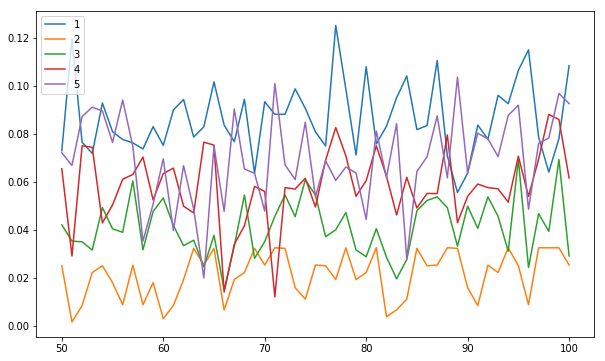

In [57]:
plt.figure(figsize=(10,6))
for depth in range(1, 6):
    plt.plot(*zip(*max_feat_trs[depth-1]), label=depth)
plt.legend();

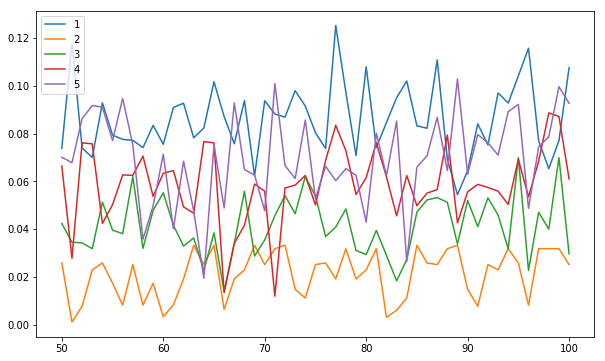

In [58]:
plt.figure(figsize=(10,6))
for depth in range(1, 6):
    plt.plot(*zip(*max_feat_tes[depth-1]), label=depth)
plt.legend();

We've omitted the target depths that we actually use to demonstrate a few that provide a clearer picture of what this tuning displays. We can pick out improvements per depth per feature count. We settle, somewhat arbitrarily due to compute time restrictions, on the depths and feature counts that we use below.

In [59]:
models_7, _, _, _ = eval_model(tree.DecisionTreeRegressor(max_depth=12, max_features=100), 
                         naive_samps, True)

models_8, _, _, _ = eval_model(tree.DecisionTreeRegressor(max_depth=8, max_features=50), 
                         pared_samps, False)

Sample Type                    Training Time      Train Set Acc      Test Set Acc     
Naive Sample                   14.08               0.14631            0.14219
N, Actor1CC=USA, Internal?     0.80               0.19618            0.16355
N, Actor1CC=USA, Actor2CC      0.98               0.17872            0.15178
Sample Type                    Training Time      Train Set Acc      Test Set Acc     
Pared Sample                   6.54               0.11720            0.11562
P, Actor1CC=USA, Internal?     0.17               0.17323            0.15468
P, Actor1CC=USA, Actor2CC      0.38               0.15354            0.13097


We note that decision trees don't perform very well compared to Ridge. We also notice a relatively larger discrepancy between training accuracy and test accuracy, which suggests that the decision tree model is fitting closer to the training set data than may be ideal. We don't see as large a split in the Ridge models accuracy. Let's try a Random Forest to improve upon this.

In [60]:
models_12, _, _, _ = eval_model(RandomForestRegressor(n_estimators=40, max_depth=12, max_features=80, n_jobs=3), 
                                naive_samps, True)

models_12, _, _, _ = eval_model(RandomForestRegressor(n_estimators=40, max_depth=12, max_features=80, n_jobs=3), 
                                pared_samps, False)

Sample Type                    Training Time      Train Set Acc      Test Set Acc     
Naive Sample                   57.42               0.19276            0.18770
N, Actor1CC=USA, Internal?     3.00               0.23813            0.21136
N, Actor1CC=USA, Actor2CC      3.25               0.22436            0.20206
Sample Type                    Training Time      Train Set Acc      Test Set Acc     
Pared Sample                   52.10               0.21487            0.20852
P, Actor1CC=USA, Internal?     2.35               0.24349            0.19736
P, Actor1CC=USA, Actor2CC      2.74               0.24491            0.21253


While the accuracy has improved, we still notice some potential signs of overfitting. This is quite surprising given that random forests are more robust against this, but it's likely due to the fact that our data is so sparse. Large number of estimators might be required to compensate for this, and even still random forests don't always perform well on sparse data.

Now we try GradientBoosting, which performs the best of our tree based methods. For the sake of computing time, we only train on the pared samples.

In [61]:
models_14, _, _, _ = eval_model(GradientBoostingRegressor(n_estimators=200,
                                                          learning_rate=.2,
                                                          max_depth=3,
                                                          max_features=50), 
                          pared_samps, False)

Sample Type                    Training Time      Train Set Acc      Test Set Acc     
Pared Sample                   100.83               0.26646            0.26262
P, Actor1CC=USA, Internal?     5.70               0.25669            0.23709
P, Actor1CC=USA, Actor2CC      6.25               0.27170            0.25731


We note that this performance is in fact comparable to the results we achieved with Ridge regression. Some further tuning and more compute time and it may be able to outperform Ridge. However, it is at the cost of far less interpretability. It will be useful in this case to also gain some insight into what is causing AvgTone predictions to change, and so we still favor Ridge in the end.

## KNN

Finally, we look at KNN for completeness. It takes far too long to make predictions, as it has to compute distances between a large number of points and so we only demonstrate it on our simplest sample.

In [20]:
models_16, models_samps_2, _, _ = eval_model(KNeighborsRegressor(), 
                                       [("P, Actor1CC=USA, Internal?    ", 
                                         ICM_INT_sample(test_samp, 'USA'))], False)

Sample Type                    Training Time      Train Set Acc      Test Set Acc     
P, Actor1CC=USA, Internal?     123.98               0.27322            0.08244


# Results

To construct our final models, we build one based on the entire pared sample as a ridge regression, and one taking the restricted "Actor1CountryCode" approach, but applying it to every country in our sample so that we have an individual model for each Actor1CountryCode. While the accuracy of the naive samples were better in our above tests for Ridge, it was not considerably more so that it was deemed worth sacrificing the simpler interpretability, and its computational performance which allows us to use more data for training. 

In [15]:
final_samp = init_sample(gdelt, .4)

final_pared_samps = [("Pared Sample                  ", final_samp)]

countries = list(final_samp['Actor1CountryCode'].value_counts().index)
ICM_INT_samps = []

for country in countries:
    new_sample = ICM_INT_sample(final_samp, country)
    if len(new_sample) < 10:
        print("Omitting sample for ", country, " due to small size of ", len(new_sample))
        continue
    ICM_INT_samps.append(("Actor1CC=" + str(country) + "                    ", ICM_INT_sample(final_samp, country)))

Omitting sample for  SCN  due to small size of  9
Omitting sample for  LAM  due to small size of  8
Omitting sample for  ROM  due to small size of  3
Omitting sample for  PRI  due to small size of  1
Omitting sample for  CAU  due to small size of  1


In [22]:
final_pared_model, model_samp, _, _ = eval_model(Ridge(), final_pared_samps, False)

Sample Type                    Training Time      Train Set Acc      Test Set Acc     
Pared Sample                   88.33               0.27187            0.27167


In [ ]:
final_pared_model = final_pared_model[0]

In [57]:
feat_cols = model_samp[0].drop(['AVG(AvgTone)'], axis=1).columns
coef_df = pd.DataFrame(final_pared_model.coef_, index=feat_cols)
coef_df.iloc[-21 :-1,:]

,0
EventRootCode_01,0.379582
EventRootCode_02,0.780692
EventRootCode_03,1.821899
EventRootCode_04,1.449978
EventRootCode_05,2.211764
EventRootCode_06,1.269154
EventRootCode_07,1.288310
EventRootCode_08,0.277480
EventRootCode_09,-0.096625
EventRootCode_10,0.086332


We can confirm in the coefficients make intuitive sense. As the EventRootCode increases in number, we end up with increasingly violence verbs, and we can see that the effect upon the AvgTone trends negatively as the EventRootCode number increases.

In [58]:
final_country_models, final_country_samps, all_trs, all_tes = eval_model(Ridge(), ICM_INT_samps, False, trim_verbose=False)

Sample Type                    Training Time      Train Set Acc      Test Set Acc     
Actor1CC=USA                     0.63               0.22618            0.22199
Actor1CC=GBR                     0.18               0.21761            0.21391
Actor1CC=RUS                     0.15               0.13354            0.13710
Actor1CC=CHN                     0.14               0.16917            0.17307
Actor1CC=FRA                     0.11               0.16044            0.14851
Actor1CC=ISR                     0.10               0.28331            0.29605
Actor1CC=DEU                     0.09               0.20988            0.19937
Actor1CC=AUS                     0.09               0.22607            0.23178
Actor1CC=CAN                     0.09               0.24192            0.22364
Actor1CC=EUR                     0.08               0.12275            0.11245
Actor1CC=TUR                     0.07               0.18474            0.18676
Actor1CC=SAU                     0.08       

Actor1CC=HRV                     0.01               0.19576            0.09588
Actor1CC=UZB                     0.01               0.37142            0.27101
Actor1CC=LVA                     0.01               0.29093            0.14923
Actor1CC=SRB                     0.01               0.25438            0.25163
Actor1CC=NAM                     0.01               0.35338            0.30883
Actor1CC=NER                     0.01               0.31037            0.14154
Actor1CC=GTM                     0.01               0.30315            0.27298
Actor1CC=GMB                     0.01               0.32145            0.25514
Actor1CC=ALB                     0.01               0.20517            0.12830
Actor1CC=BWA                     0.01               0.26307            0.07290
Actor1CC=CMR                     0.01               0.30053            0.30683
Actor1CC=AGO                     0.01               0.33111            0.23331
Actor1CC=KGZ                     0.00               

In [71]:
final_country_lens = [len(samp) for samp in final_country_samps]
final_country_lens = np.array(final_country_lens)

61707.911862353314

In [75]:
print("Overall Training Accuracy: ", np.mean(all_trs))
print("Overall Training Accuracy Standard Deviation: ", np.std(all_trs))
print("Overall Test Accuracy: ", np.mean(all_tes))
print("overall Test Accuracy (Weighted): ", (final_country_lens * all_tes).sum() / final_country_lens.sum())
print("Overall Test Accuracy Standard Deviation: ", np.std(all_tes))

Overall Training Accuracy:  0.28514610986680294
Overall Training Accuracy Standard Deviation:  0.11486052175685636
Overall Test Accuracy:  0.184305870355529
overall Test Accuracy (Weighted):  0.20656824458074913
Overall Test Accuracy Standard Deviation:  0.14588518939344636


# How to Use

The AvgTone column of the GDELT dataset is derived from articles discussing the event. It's utility is in providing a general sense of the "impact" or "extent" of an event. A riot with a mildly negative AvgTone of -1 is not as serious as one with -25. Our final predictive model is only based on a few characteristics: Actor1CountryCode, Actor2CountryCode, EventRootCode, Actor1Type1Code, Actor2Type1Code, and NumMentions. The last one of these can't be known with any certainty early on, but all former columns may be figured out early on in an event. Then the model could be used to determine a rough estimate of the AvgTone. The use of this is that the GDELT data set is tracking events on a global scale, far too many for even an army of people to pay attention to. This model could be used as part of a system that notifies the users of high priority events that need a watchful eye.

The deployed model could run continuously as information comes in on these various columns. This would require an infrastructure different from GDELT which prioritized early predictions on the variables we're using. The model could also continue to train itself on new data every so often so that it doesn't fall out of date on new trends.

# Future Work

The data used here is cut down considerably from what's available from the GDELT dataset. The most obvious way to improve the model is then to include other features that prove to be useful to predicting the AvgTone. It seems likely that there would be others not yet included which could include the performance. 

It would also be useful to spend more time on understanding what is affecting the AvgTone movements, and so we should continue to prioritize interpretable models. Perhaps we could discover changing relationships between countries based on changing AvgTone trends in our model.